[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab4_unets.ipynb)

# Cancer Detection and UNet
---

In this lab, we will learn on a dataset for a real-world task. We will be performing cancer detection: given a photo of a slide of cells, identify the areas of cancerous cells. We will be performing image segmentation: classifying each pixel as cancerous or non-cancerous.

You will create a large network, using the U-net architecture described below. The main goal of this lab is for you to understand how to create complex network architectures capable of learning difficult tasks.

---
## Grading Criteria
* 20% Completed dataset analysis
* 20% Correct training and validation functions
* 10% Proper creation, training, and validation of smallest-possible network for this task
* 40% Proper creation, training, and validation of the U-net architecture
* 10% Reasonable validation results achieved with the U-net architecture
---

In [1]:
import os
import gzip
import tarfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils, datasets

Set the global variable `device = torch.device("cpu")`. You can change this to `cuda` once you know everything is working, that way you don't run out of your GPU resources on Colab.

Remember to use a CPU runtime when not using the GPU. Colab has strict limits on how long you can use a GPU runtime.

In [2]:
device = torch.device("cuda")

WARNING: You may run into an error that says `RuntimeError: CUDA out of memory.`

If you get this error immediately when training, then your batch is probably larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime.
If you get this error after training for multiple steps then you probably are not freeing up computation graph, i.e. you are storing `loss` instead of `loss.item()`. 

In [3]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)

  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]

  def __len__(self):
    return len(self.dataset_folder)

---

# Part 1: Analyzing the Dataset

First things first.
Let's take a look at the dataset.

*Note: This may take a while to download; it may be quicker to upload it to Colab from your machine.*

In [4]:
train_dataset = CancerDataset("/tmp/Datasets/cancer", train=True)
val_dataset = CancerDataset("/tmp/Datasets/cancer", train=False)

Print out the lengths of your train and validation datasets, so you know how much data you are working with.

In [5]:
print("Training length:", len(train_dataset))
print("Validation length:", len(val_dataset))

Training length: 1342
Validation length: 175


Now you should examine a single data instance from the dataset.
We'll use pos_test_000072.png (`val_dataset[172]`) as an example throughout training.
Collect the image and the cancer labels from pos_test_000072.png (i.e. `val_x, val_y = val_dataset[172]`).

In [6]:
val_x, val_y = val_dataset[172]

Let's analyze the `x` data first. Print out the shape and dtype of `val_x` below.

In [7]:
print("val_x shape:", val_x.shape)
print("val_x dtype:", val_x.dtype)

val_x shape: torch.Size([3, 512, 512])
val_x dtype: torch.float32


`x` has 3 channels, which likely means that `x` is an RGB image (which it is).
Since RGB images can be values between [0, 255] or [0, 1] we should print out the min and max values of x to see which.
Print out the min and max values of x below.

In [8]:
print("val_x min:", torch.min(val_x))
print("val_x max:", torch.max(val_x))

val_x min: tensor(0.0235)
val_x max: tensor(0.9765)


The values are between [0, 1], which is good because that means we don't have do any normalization.

Now implement a `plot_image()` function which should plot an `x` variable.
You can use the `plt.imshow()` function to plot an RGB image.

Plot `val_x` and validate that it looks the same as the image file in "tmp/Datasets/cancer/cancer_data/cancer_data/inputs_test/0/pos_test_000072.png" in the dataset.

*Note: Per PyTorch convention an image has its channels at the 0th dimension (ignoring the batch dimension), but matplotlib expects the channel dimension at the 2nd dimension. You will need to permute the dimensions the plot it correctly*.

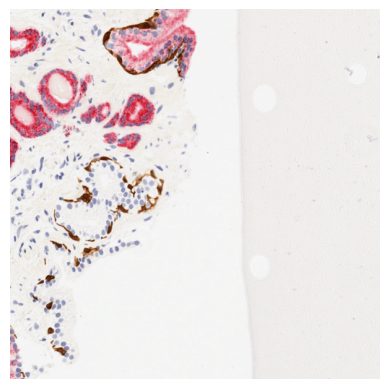

In [9]:
def plot_image(x: torch.Tensor):
    permuted = x.permute(1, 2, 0)
    plt.imshow(permuted)
    plt.axis('off')
plot_image(val_x)

Now let's have a look at the cancer labels `y`; print out the shape and dtype of `val_y`.

In [10]:
print("val_y shape:", val_y.shape)
print("val_y dtype:", val_y.dtype)

val_y shape: torch.Size([512, 512])
val_y dtype: torch.float32


`y` has 1 channel (but it is squeezed so there is no channel dimension).
This most likely means that `y` is a grayscale image (which it is).

Implement `plot_cancer()` which should plot a `y` variable. You can use the `plt.imshow()` function to plot a grayscale image (pass in the `cmap="gray"` argument to make the image grayscale).

Plot `val_y` and validate that it looks like the label image "tmp/Datasets/cancer/cancer_data/cancer_data/outputs_test/0/pos_test_000072.png" in the dataset.

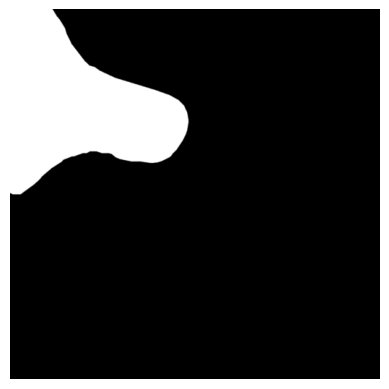

In [11]:
def plot_cancer(y):
    plt.imshow(y, cmap='gray')
    plt.axis('off')

plot_cancer(val_y)

The cancer is white which means that our cancerous label is 1 and our noncancerous label is 0.
Interestingly, the dtype of `y` is a float, but we were expecting cancer labels (i.e. cancerous vs noncancerous).
Use `torch.unique()` below to see all the unique values of `y`.

In [12]:
print("Unique y values:", torch.unique(val_y))

Unique y values: tensor([0.0000, 0.0157, 0.0627, 0.0706, 0.1098, 0.1255, 0.1569, 0.1725, 0.1804,
        0.2980, 0.3137, 0.3451, 0.3608, 0.4549, 0.5020, 0.5176, 0.5490, 0.6431,
        0.6588, 0.6902, 0.7059, 0.7137, 0.7529, 0.8275, 0.8431, 0.8745, 0.8902,
        0.8941, 0.9373, 0.9843, 1.0000])


While 0 and 1 are in `y`, we have other values inbetween. For classification with cross entropy, we need `y` to be integers only. The original image was only black and white, so these non-integer values are due to the image being resized when it was loaded in. We need to think about the dataset and what we want to accomplish to determine how to treat these values: do we round, truncate, or ceiling?

Because this is due to the resizing, these values only occur on the outer edge of the cancer label blobs. For this task, we want to identify regions with cancer, but we don't really need pixel accuracy - we just want the doctors to know to look there for cancer. So, we can truncate these non-one values by calling `y.long()`.

In [13]:
val_y = val_y.long()

You should also add a batch dimension to `val_x` and put it on the `device` so we can pass it through the network later.

In [14]:
val_x = val_x.unsqueeze(0).to(device)
print(val_x.shape)

torch.Size([1, 3, 512, 512])


Now retrieve some baseline accuracy information about the train and validation datasets.
- How many images have cancerous cells in the dataset
- On average how likely is a pixel going to be cancerous

Print this information below.

In [15]:
def summary_stats(dataset):
    cancerous_image_count = 0
    cancerous_pixels_count = 0
    for x, y in dataset:
        num_cancerous_pixels = torch.sum(y == 1)
        if num_cancerous_pixels > 0:
            cancerous_image_count +=1
        cancerous_pixels_count += num_cancerous_pixels
    
    total_pixels = (len(dataset) * 512 * 512)
    cancerous_pixel_probability = cancerous_pixels_count / total_pixels

    return cancerous_image_count, cancerous_pixel_probability

In [16]:
train_count, train_probability = summary_stats(train_dataset)

print("Training cancerous image count:", train_count)
print("Training cancerous pixel probability:", train_probability)

Training cancerous image count: 668
Training cancerous pixel probability: tensor(0.1614)


In [17]:
val_count, val_probability = summary_stats(val_dataset)

print("Validation cancerous image count:", val_count)
print("Validation cancerous pixel probability:", val_probability)

Validation cancerous image count: 73
Validation cancerous pixel probability: tensor(0.0991)


This dataset is very skewed towards non-cancerous data. This makes sense: most cells are non-cancerous, and images that contain cancer will have non-cancerous areas. For our model to be successful, we need to get higher than this baseline accuracy, so our validation accuracy should be over 90%.

## Network outputs

Now that we understand our input images and our label images, what should our network's predictions look like?

Because we are doing pixelwise classification, we want to output logits (unnormalized probabilities) for each pixel in our input. So the spatial dimension, i.e. HxW, of the network's output will be the same as those of our input.

#### Loss
If you recall from lab 1, when we implemented cross entropy, our predicted logits had a shape of `(B, K)`, where `K` was the number of classes, and our target classes had a shape of `(B,)`, which was used to index into our predicted logits. 
This will work similarly for pixelwise cross entropy, the predicted logits $\hat y$ will have a shape of `(B, K, H, W)`, where `K=2` for our dataset, and the target $y$ will have a shape of `(B, H, W)`. 
You can use PyTorch's `F.cross_entropy()` function to compute the cross entropy loss. 

#### Accuracy
Implement an accuracy function which compute the pixelwise accuracy between $\hat y$ and $y$. 

*Note: Don't forget to use `torch.no_grad()` and since we are just interested in number, return the accuracy as a number, using `.item()`.*

In [18]:
def cancer_detection_accuracy(y_hat, y):
    with torch.no_grad(): 
        predicted = y_hat.argmax(dim=1)
        correct = torch.sum(predicted == y)
        total = y.numel()
        accuracy = correct / total

    return accuracy.item()

Now create a test function for `cancer_detection_accuracy`. Your function should:
- Call `cancer_detection_accuracy()` twice, with two different predictions and accuracies.
- Be simple, but nontrivial. Don't compare all (non)cancerous predictions with all (non)cancerous targets.

Don't forget to add a batch dimension, even if it is just a batch size of 1.

*Note: We recommend you create small images since they are easier to visualize and you have different values for each dimension, except for maybe H and W, because `B, C, H, W = 2, 2, 2, 2` can be harder to understand than `B, C, H, W = 1, 2, 3, 3`.*

In [19]:
def test_cancer_detection_accuracy():
    torch.manual_seed(0)
    image_1 = torch.zeros((1, 3, 2, 2))
    image_2 = torch.ones((1, 3, 2, 2))
    image_3 = torch.Tensor([
        [
            [1, 1],
            [0, 0]
        ],
        [
            [1, 1],
            [0, 0]
        ],
        [
            [1, 1],
            [0, 0]
        ],
    ])
    
    assert cancer_detection_accuracy(image_1, image_1) == 1.0
    assert cancer_detection_accuracy(image_1, image_2) == 0.0
    assert cancer_detection_accuracy(image_1, image_3) == 0.5

test_cancer_detection_accuracy()

## Dataloaders

Now that we have the datasets, put them into dataloaders for training. Define a batch size (should be pretty small because we'll use a huge network). You should always shuffle your training dataset, but this time it is even more important because the dataset has all negative examples first. If you don't shuffle, your network will learn to predict all pixels as non-cancerous.

In [20]:
batch_size = 16

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True
)

for batch_x, batch_y in train_loader:
    print("Batch x shape:", batch_x.shape)
    print("Batch y shape:", batch_y.shape)
    break

Batch x shape: torch.Size([16, 3, 512, 512])
Batch y shape: torch.Size([16, 512, 512])


---

# Part 2: Training and Validation

Now that we understand the data, we'll create training and validation functions BEFORE creating our network.

We'll start with validation, since its simpler. Create a validation function that takes in a network and validation dataloader and returns the mean cross-entropy loss (just the value, not the tensor) and pixel-wise accuracy over the dataset. Don't forget to use `torch.no_grad()`.

In [21]:
def validation(network: torch.nn.Module, dataloader: DataLoader):
    loss_sum = 0.0
    acc_sum = 0.0
    n = 0

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Validating", leave=False):
            x, y = x.to(device), y.to(device).long()

            y_hat = network(x)
            loss = F.cross_entropy(y_hat, y)
            loss_sum += loss.item()

            accuracy = cancer_detection_accuracy(y_hat, y)
            acc_sum += accuracy

            n += 1

    mean_loss = loss_sum / n
    mean_accuracy = acc_sum / n

    return mean_loss, mean_accuracy

Because this is a very visual task, we also want to see how our model's predictions change over time. We'll use a single image: `val_dataset[172]` and store our model's prediction on it each time we perform validation. At the end, we can print out the images to see how our model improves over time. Create a function that takes in an image tensor of shape `(1, C, H, W)` (batch size of 1) and returns a prediction image of shape `(H, W)`, i.e remove the batch dimension and argmax the channel dimension to get the pixel predictions. Don't forget to use `torch.no_grad()`.

In [22]:
def get_prediction(net: torch.nn, x: torch.Tensor):
    with torch.no_grad():
        y_hat = net(x)
        prediction = y_hat.argmax(dim=1)
        prediction = prediction.squeeze(0)
        return prediction

Create a function(s) to plot your training/validation losses on the same plot and your training/validation accuracies on the same plot. 
Label your axes and add a legend to make your plots legible. 

In [23]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.xlabel("Log Interval")
    plt.ylabel("Loss")
    plt.title("Network Loss")
    plt.legend()
    plt.show()

def plot_accuracies(train_acc, val_acc):
    plt.clf()
    plt.plot(train_acc, label='Training')
    plt.plot(val_acc, label='Validation')
    plt.xlabel("Log Interval")
    plt.ylabel("Accuracy")
    plt.title("Network Accuracy")
    plt.legend()
    plt.show()

Create another function to plot 5 image predictions.

In [24]:
def plot_images(predictions: list[torch.Tensor]):
    plt.clf()
    n = len(predictions)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))

    for i, ax in enumerate(axes):
        ax.imshow(predictions[i].cpu(), cmap="gray")
        ax.axis("off")
    
    plt.show()

---

Now create your training function. This should be similar to what we've done in lab 3, but remember that your data and labels are different sizes from lab 3's dataset.

Store your training accuracy and losses every `log_interval` steps and validate every `val_interval` steps. Also store 5 predictions of `val_x` dispersed evenly throughout training. 
Return the statistics you've gathered (losses, accuracies, and val image predictions).

In [25]:
def train(net, optimizer, train_dataloader, val_dataloader, n_minibatch_steps, log_interval, val_interval, val_im_delay, val_x):
    # Train net on the training data, keeping track of loss, accuracy, and predictions on val_x
    # Return losses and accuracies on both training and validation datasets, and 5 images
    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []
    predictions = []

    prediction_interval = n_minibatch_steps // 5

    step = 0

    with tqdm(total=n_minibatch_steps, desc="Training Progress") as pbar:
        while step < n_minibatch_steps:
            for x, y in train_dataloader:

                if step >= n_minibatch_steps:
                    break

                x, y = x.to(device), y.to(device).long()

                optimizer.zero_grad()

                y_hat = net(x)

                loss = F.cross_entropy(y_hat, y)

                loss.backward()
                optimizer.step()

                if step % log_interval == 0:
                    training_losses.append(loss.item())
                    accuracy = cancer_detection_accuracy(y_hat, y)
                    training_accuracies.append(accuracy)


                if step % val_interval == 0:
                    val_loss, val_accuracy = validation(net, val_dataloader)
                    val_losses.append(val_loss)
                    val_accuracies.append(val_accuracy)

                if (step + val_im_delay) % prediction_interval == 0:
                    prediction = get_prediction(net, val_x)
                    predictions.append(prediction)

                step += 1
                pbar.update(1)
                
    return training_losses, training_accuracies, val_losses, val_accuracies, predictions

---

# Part 3: Training Smallest-Possible Network

While we want to use the UNet on this problem, we should make sure our training and validation runs with a smaller network. Doing this first makes sure that we can focus on bugs in the training and validation loop before focusing on debugging the network itself. And this makes sure that we understand what our inputs and outputs should be.

Before reading further, answer the following question:

What is the smallest-possible convolutional network that can solve this task?

In [26]:
# CREATE SMALLEST NETWORK
small_net = nn.Conv2d(3, 2, kernel_size=1).to(device)

---

You should have created a one-layer network with 3 in-channels and 2 out-channels, with a 1x1 convolution. This network obviously won't learn well, but it will be useful for quickly testing and debugging our training and validation functions.

In [27]:
torch.manual_seed(0)

# Create an optimizer for your network
small_optimizer = torch.optim.Adam(small_net.parameters(), lr=.001)

n_minibatch_steps = 100
log_interval = 10
val_interval = 10
val_im_delay = 0

# Train for a few training steps: enough to gather some stats
train_losses, train_accs, val_losses, val_accs, val_images = train(
    net=small_net, 
    optimizer=small_optimizer, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    n_minibatch_steps=n_minibatch_steps, 
    log_interval=log_interval, 
    val_interval=val_interval, 
    val_im_delay=val_im_delay, 
    val_x=val_x
)

Training Progress: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


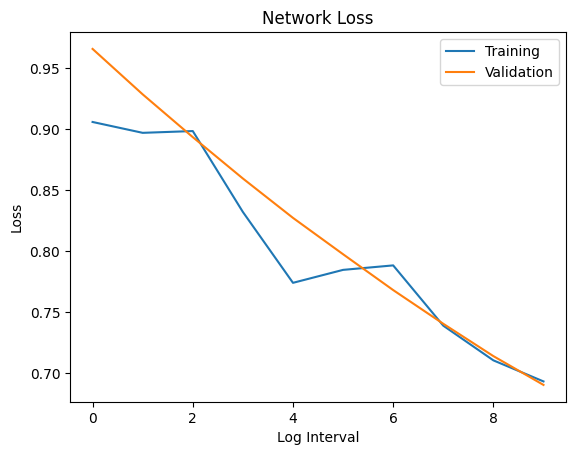

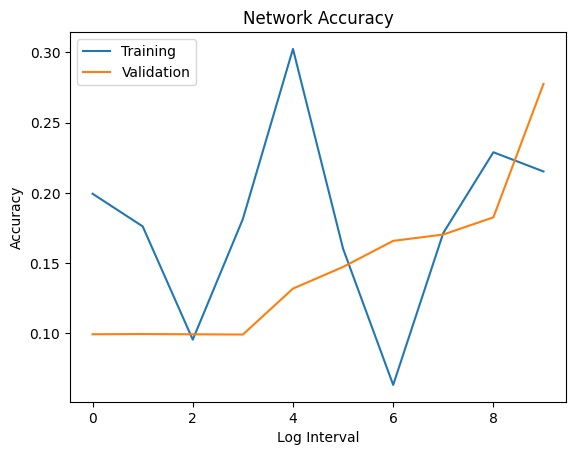

<Figure size 640x480 with 0 Axes>

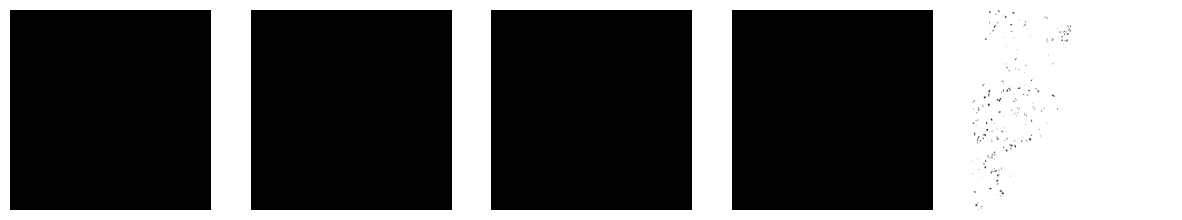

(None, None, None)

In [28]:
# Create your loss and accuracy graphs, and print out the 5 validation images:
# We do not expect this network to have learned well.
plot_losses(train_losses, val_losses), plot_accuracies(train_accs, val_accs), plot_images(val_images)

In [29]:
# We don't need this network anymore, so we'll delete it to free up GPU space
del small_net, small_optimizer, train_losses, train_accs, val_losses, val_accs, val_images

torch.cuda.empty_cache()

---

# Part 4: Implementing the UNet

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf)

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)
<!-- <img src="https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400" width="1600" height="1200"/> -->

You will implement the UNet with some simplifying adjustments.
The original UNet does not pad their convolutions, so their output is smaller than their input. 
Your input and output are the same size so you should pad your convolutions. 
The only time height and width should change are from "max pool" and the "up-conv". 
This means you no longer need to "crop" the cross connections, since both sides of the U should have the same spatial dimensions. 

This is a large complex network structure and due to the cross connections, you can't just stick a bunch of layers into `nn.Sequential`. 
This network does have a clear repeating pattern of blocks that move down (left side of U) and blocks that move up (right side of U). 
Just like how we use functions to made our code more modular, we'll create two modules to capture that repeating structure to simplify our final network.

Implement `DownBlock` (left side of U): The `DownBlock` incorporates 2 sequential convolution layers (with nonlinearities) followed by a downsampling (`nn.MaxPool2d`). 
It should return the downsampled image and the cross connection output.
You should NOT use `copy` or `clone` on the cross connection output to do the "copy and crop" operation; just return the same tensor you passed into `MaxPool2D` layer.

In [30]:
# You are welcome (and encouraged) to use the built-in batch normalization, nn.BatchNorm2d, and dropout layers, nn.Dropout.

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(.3),
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        cross_connection = self.model(x)
        down_sample = self.max_pool(cross_connection)
        return down_sample, cross_connection 

Implement `UpBlock` (right side of U): The `UpBlock` incorporates an upsampling (i.e. `nn.ConvTranspose2d`) followed by 2 sequential convolution layers (with nonlinearities). Its input should be a downsampled image, `x`, and the cross connection output, `cross_output`, from a `DownBlock`.

In [31]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(.3),
        )

    def forward(self, x, cross_output):
        up_sample = self.conv_transpose(x)
        x_cat = torch.cat([up_sample, cross_output], dim=1)
        y_hat = self.model(x_cat)
        return y_hat

Test below that your `DownBlock` and `UpBlock` work correctly.
Create a function `test_updown_block()` which instantiates a `DownBlock` and `UpBlock` and passes in a dummy image `x = torch.zeros((2, 4, 16, 16))`.
The downsampled output of your `DownBlock` should be passed through the provided `mid_conv` layer (representing the bottom layer in the UNet) before being passed to the `UpBlock`. 
You will assert that the the cross-connection output of your `DownBlock` and the output of your `UpBlock` have the shape of `(2, 8, 16, 16)`.
Remember to use `torch.no_grad()`.

In [32]:
def test_updown_block():
    with torch.no_grad():
        x = torch.zeros((2, 4, 16, 16))
        down = DownBlock(4, 8)
        up = UpBlock(16, 8)
        mid_conv = nn.Sequential(nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), nn.ReLU())
        
        down_sample, cross_connection = down(x)
        mid_output = mid_conv(down_sample)
        up_output = up(mid_output, cross_connection)

        assert cross_connection.shape == (2, 8, 16, 16)
        assert up_output.shape == (2, 8, 16, 16)

test_updown_block()

Implement the `UNet` using your `UpBlock` and `DownBlock` modules.
You will additionally need to add layers for the bottom of the U and the final output layer.
You do not need to use the same number of channels as the UNet paper. It is recommended you use fewer channels for faster training and less memory consumption. `[8, 16, 32, 64]` are a good choice for channel sizes.

*Note: If you want to store `UpBlock`s and `DownBlock`s in a list then use the `nn.ModuleList()` which is a module that operates like a list, but exposes the modules to PyTorch.*

In [33]:
class UNet(nn.Module):
    def __init__(self, channels=(8, 16, 32, 64)) -> None:
        super().__init__()
        # Initialize all modules for the full UNet
        # Use the `channels` parameter to specify the number of channels on each level of the U
        self.down_blocks = nn.ModuleList()
        in_channels = 3 # RGB
        for out_channels in channels:
            self.down_blocks.append(DownBlock(in_channels, out_channels))
            in_channels = out_channels

        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels[-1], channels[-1] * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels[-1] * 2),
            nn.ReLU(),
            nn.Conv2d(channels[-1] * 2, channels[-1] * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels[-1] * 2),
            nn.ReLU(),
        )

        self.up_blocks = nn.ModuleList()
        in_channels = channels[-1] * 2
        reversed_channels = list(reversed(channels))
        for out_channels in reversed_channels:
            self.up_blocks.append(UpBlock(in_channels, out_channels))
            in_channels = out_channels 

        self.final_conv = nn.Conv2d(channels[0], 2, kernel_size=1) 

    def forward(self, x):
        cross_connections = []

        for down in self.down_blocks:
            x, cross_connection = down(x)
            cross_connections.append(cross_connection)

        x = self.bottleneck(x)

        for idx, up_block in enumerate(self.up_blocks):
            cross_connection = cross_connections[-(idx + 1)]
            x = up_block(x, cross_connection)

        y_hat = self.final_conv(x)

        return y_hat

Test `UNet` by making sure that it takes a batch of input images `x` and returns an appropriately-shaped output.

In [34]:
def test_UNet_shapes():
    x = torch.zeros((2, 3, 128, 128)) 
    u_net = UNet()
    
    with torch.no_grad():
        y_hat = u_net(x)
        print(y_hat.shape)
        # assert y_hat.shape == (8, 1, 512, 512)
        
test_UNet_shapes()

torch.Size([2, 2, 128, 128])


---

# Training and Testing UNet

Train `UNet` below and get a better than baseline accuracy. For Colab/Kaggle users, we recommend training with a small `UNet` first on the CPU and then scaling up the `UNet` and training on the GPU. 

In [35]:
u_net = UNet().to(device)
optimizer = optim.Adam(u_net.parameters(), lr=.001)


# Here are some example hyperparameters: feel free to play around with them for better results
n_minibatch_steps = 100
log_interval = 10
val_interval = 10
val_im_delay = 0

train_losses, train_accs, val_losses, val_accs, val_images = train(
    net=u_net, 
    optimizer=optimizer, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    n_minibatch_steps=n_minibatch_steps, 
    log_interval=log_interval, 
    val_interval=val_interval, 
    val_im_delay=val_im_delay, 
    val_x=val_x
)

Training Progress: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


Plot your training/validation losses and accuracies. 

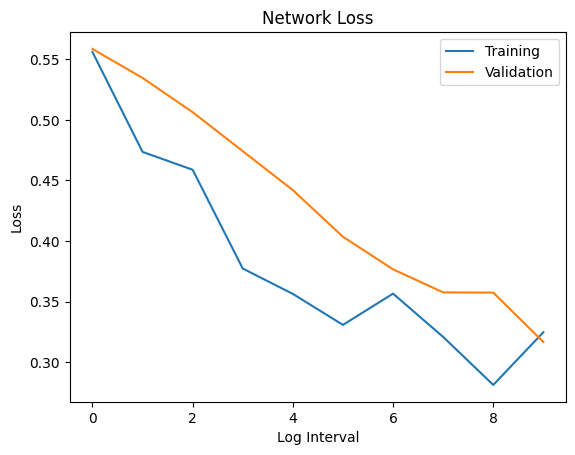

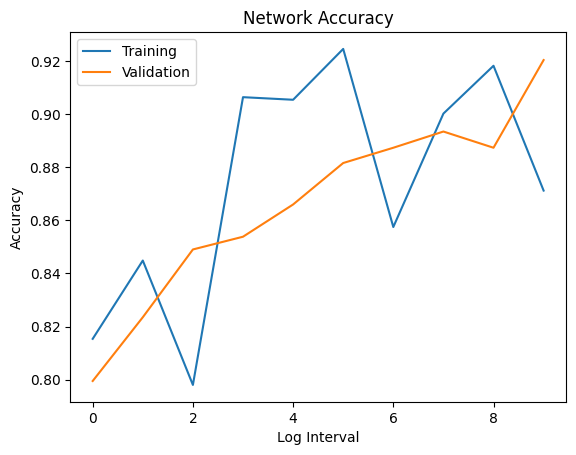

(None, None)

In [36]:
plot_losses(train_losses, val_losses), plot_accuracies(train_accs, val_accs)

Visualize the 5 predictions of `val_x`. Your images should start to look like the `plot_cancer()` image you made above (signs of cancer in the top left corner). 

<Figure size 640x480 with 0 Axes>

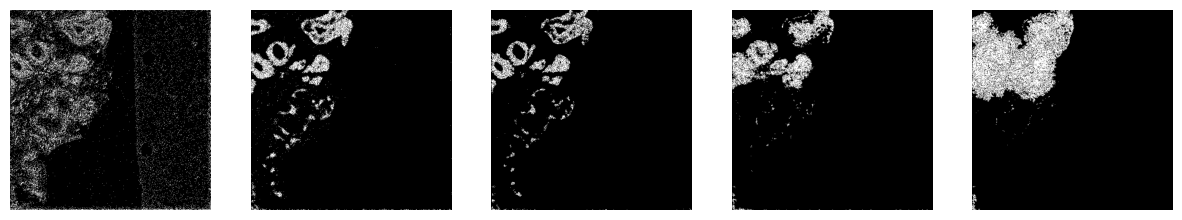

In [37]:
plot_images(val_images)